In [50]:
import json
from pathlib import Path
from fnmatch import fnmatch
from pymavlink import mavutil
from inspect import getfullargspec
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import piexif
import os
from datetime import datetime
from csv import DictWriter


tlog_file_name = '/Users/matthewtoberman/Downloads/2023-10-04 11-54-33.tlog'

image_folder_path = '/Users/matthewtoberman/Downloads/Left_4A_half_edited'

position_log_file_name = '/Users/matthewtoberman/Downloads/csv_test/test.csv'



class Telemetry:

    DEFAULT_FIELDS = {

        "SYSTEM_TIME": [ "time_boot_ms",
                        "time_unix_usec" ],

            "GLOBAL_POSITION_INT": [ "time_boot_ms",
                                "alt",
                                "relative_alt",
                                "hdg",
                                "vz",
                                "vx",
                                "vy",
                                "lat",
                                "lon"],

            "GPS_INPUT": ["hdop",
                        "satellites_visible",
                        "fix_type",
                        "lat",
                        "lon",
                        "vdop",
                        "horiz_accuracy"],

            "SCALED_PRESSURE": ["time_boot_ms",
                            "press_abs",
                            "temperature"],

            "VFR_HUD" : ['alt']
    }
    def __init__(self, log_file, fields=DEFAULT_FIELDS,
                 dialect='ardupilotmega'):
        ''' Creates a tlog parser on 'log_file', extracting 'fields'.
        'log_file' can be a string filename/path, or pathlib.Path instance.
        'fields' is either a dictionary in the form {'TYPE': ['attr']/None},
            or a string filename/path to a json/text file with the same
            structure. Specifying None (null if in a file) instead of an
            attribute list gets all the attributes for that type.
            Defaults to Telemetry.DEFAULT_FIELDS.
        'dialect' is a string specifying the mavlink parsing dialect to use.
            Default 'ardupilotmega'.
        '''
        self.log_file = str(log_file) # mavutil doesn't use Path
        self.mlog = mavutil.mavlink_connection(self.log_file, dialect=dialect)

        self._init_fields(fields)

    def _init_fields(self, fields):
        ''' Determine CSV fields and populate None attribute lists. '''
        if isinstance(fields, (str, Path)):
            with open(fields) as field_file:
                fields = json.load(field_file)

        self.csv_fields = ['timestamp']
        nan = float('nan') # start with non-number data values
        self.data = [nan]
        self.offsets = {}
        for type_, field in fields.items():
            if field is None:
                type_class = f'MAVLink_{type_.lower()}_message'
                fields[type_] = \
                    getfullargspec(getattr(mavutil.mavlink,
                                           type_class).__init__).args[1:]
            self.offsets[type_] = offset = len(self.csv_fields)
            self.csv_fields.extend(f'{type_}.{attr}' for attr in fields[type_])
            self.data.extend(nan for _ in range(len(self.csv_fields) - offset))

        self.fields = fields
        self.type_set = set(fields) # put major fields in a set

    def __enter__(self):
        return self

    def __exit__(self, *exc):
        self.mlog.close()

    def __iter__(self):
        while "messages available":
            msg = self.mlog.recv_match(type=self.type_set)
            if not msg:
                break
            m_type = msg.get_type()

            if m_type == 'BAD_DATA':
                print('bad data recorded')
                continue
            elif not self.match_types(m_type, self.type_set):
                # keep going if the message is the wrong type
                # NOTE: specifically relevant because recv_match internal
                #       'skip_to_type' function auto-includes HEARTBEAT and
                #       PARAM_VALUE messages
                continue

            yield msg

    @staticmethod
    def match_types(m_type, patterns):
        ''' Return True if m_type matches one of patterns.
        'patterns' are types but case-insensitive on Windows, and with support
            for unix-style wildcards:
                *      -> match everything
                ?      -> match a single character
                [seq]  -> match any character in seq
                [!seq] -> match any character not in seq
        '''
        return any(fnmatch(m_type, p) for p in patterns)

    def to_csv(self, output=None, csv_sep=',', verbose=True):
        '''
        NOTE: opens output in append mode
               -> can create files, but WILL NOT overwrite existing files
                  (adds to the end instead).
        '''
        if output is None:
            output = Path(self.log_file).with_suffix('.csv')
        if verbose:
            print(f'Processing {self.log_file}\n  -> Saving to {output}')

        last_timestamp = None
        adding = Path(output).is_file()
        # TODO enable stdout output for printing to terminal?
        with self as mavlink, open(output, 'a') as out_file:
            def write_line(data):
                print(csv_sep.join(data), file=out_file)
            # convert to suitable for csv output
            self.data = [str(val) for val in self.data]

            if not adding:
                write_line(self.csv_fields) # field headings

            for msg in mavlink:
                wrote_last = False
                timestamp = getattr(msg, '_timestamp', 0.0)
                data = msg.to_dict()
                if last_timestamp is not None and timestamp != last_timestamp:
                    # new timestamp, so write latest data and timestamp
                    self.data[0] = f'{last_timestamp:.8f}'
                    write_line(self.data)
                    wrote_last = True

                self._update(msg.get_type(), data, convert=str)
                last_timestamp = timestamp

            try:
                if not wrote_last: # handle last message
                    self.data[0] = f'{last_timestamp:.8f}'
                    write_line(self.data)
            except UnboundLocalError:
                print('No desired messages found in file')

    def data_parser(self):
        last_timestamp = None
        with self as mavlink:
            for msg in mavlink:
                yielded_last = False
                timestamp = getattr(msg, '_timestamp', 0.0)
                data = msg.to_dict()
                if last_timestamp is not None and timestamp != last_timestamp:
                    # new timestamp, so yield latest data and timestamp
                    self.data[0] = last_timestamp
                    yield self.data
                    yielded_last = True

                self._update(msg.get_type(), data)
                last_timestamp = timestamp

            try:
                if not yielded_last: # handle last message
                    self.data[0] = last_timestamp
                    yield self.data
            except UnboundLocalError:
                print('No desired messages found in file')

    def _update(self, type_, data, convert=lambda d: d):
        ''' Update with the latest data for 'type_'. '''
        offset = self.offsets[type_]
        for index, desired_attr in enumerate(self.fields[type_]):
            self.data[offset+index] = convert(data[desired_attr])

    @classmethod
    def logs_to_csv(cls, output, logs, fields=DEFAULT_FIELDS, csv_sep=',',
                    dialect='ardupilotmega', verbose=True):
        for log in logs:
            cls(log, fields, dialect).to_csv(output, csv_sep, verbose)

    @staticmethod
    def csv_to_df(filename, timestamp='timestamp',
                  timezone='Australia/Melbourne', **kwargs):
        ''' Returns a pandas dataframe of a csv-log, indexed by timestamp.
        'filename' is the path to a csv-file, as output by Telemetry.to_csv
        'timestamp' is the name of the timestamp column. Defaults to
            "timestamp".
        'timezone' is the location where the data was collected. Data is
            assumed to be in UTC, and is converted to the specified timezone.
            Defaults to 'Australia/Melbourne'.
        'kwargs' are additional key-word arguments to pass to pandas read_csv.
            Mostly useful for 'usecols', if not all columns are required.
        '''
      

        def parser(utc_epoch_seconds):
            return (pd.to_datetime(utc_epoch_seconds, unit='s')
                    .tz_localize('utc').tz_convert(timezone))

        return pd.read_csv(filename, index_col=timestamp,
                           parse_dates=[timestamp], date_parser=parser,
                           **kwargs)

    @classmethod
    def get_useful_fields(cls, tlogs, out='useful.json', fields=None,
                          dialect='ardupilotmega', verbose=True):
        ''' Returns a {type: [fields]} dictionary of all non-constant fields.
        'tlogs' should be an iterable of one or more string/Path filepaths.
        'out' is the filename to save to. If set to None does not save.
        'fields' a json file for a subset of fields to parse with. If left as
            None checks all fields in the file.
        'dialect' is the mavlink dialect in use. Default 'ardupilotmega'.
        'verbose' a boolean determining if progress updates should be printed.
        '''
        mavutil.set_dialect(dialect) # set dialect so field tracker is accurate
        fields = cls.__create_field_tracker(fields)
        # determine fields dictionary to initialise with
        init_fields = {type_: list(fields_)
                       for type_, fields_ in fields.items()}

        useful_types = {}

        for tlog in tlogs:
            if verbose:
                print(f'Extracting useful fields from {tlog!r}')
            with cls(tlog, init_fields, dialect) as mavlink:
                for msg in mavlink:
                    cls.__process(msg, mavlink, fields, init_fields,
                                  useful_types)

        useful_types = {t: useful_types[t] for t in sorted(useful_types)}

        if out:
            with open(out, 'w') as output:
                json.dump(useful_types, output, indent=4)
            if verbose:
                print(f'  -> Saving to {output}')

        return useful_types

    @staticmethod
    def __create_field_tracker(fields):
        ''' Create a dictionary of {type: {field: None}} for specified fields.
        If 'fields' is None gets all the types and fields from mavutil.mavlink.
        If 'fields' is a string/Path json file, reads in and replaces any
            None fields with all the valid fields for that type.
        '''
        def get_fields(type_):
            ''' Return a dict of {field: None} for all fields of type_. '''
            return {field: None for field in
                    getfullargspec(getattr(mavutil.mavlink,
                                           type_).__init__).args[1:]}

        if fields is None:
            fields = {t[8:-8].upper(): get_fields(t)
                      for t in dir(mavutil.mavlink)
                      if t.startswith('MAVLink_') and t.endswith('_message')}
        elif isinstance(fields, (str, Path)):
            fmt = 'MAVLink_{}_message'
            with open(fields) as in_file:
                fields = {type_: ({field: None for field in fields_} if fields_
                                  else get_fields(fmt.format(type_.lower())))
                          for type_, fields_ in json.load(in_file).items()}

        return fields

    @staticmethod
    def __process(msg, mavlink, fields, init_fields, useful_types):
        msg_type = msg.get_type()

        to_remove = []
        for field, data in fields[msg_type].items():
            msg_data = getattr(msg, field)
            if data is None:
                fields[msg_type][field] = msg_data
            elif msg_data != data:
                # data changes -> useful field
                if msg_type not in useful_types:
                    useful_types[msg_type] = []
                useful_types[msg_type].append(field)
                to_remove.append(field)
                if not fields[msg_type]:
                    # all fields useful -> stop checking type
                    mavlink.type_set.pop(msg_type)
                    init_fields.pop(msg_type)

        for field in to_remove:
            fields[msg_type].pop(field)




combined_CSV_output_filename = None
Telemetry.logs_to_csv(combined_CSV_output_filename, [tlog_file_name],Telemetry.DEFAULT_FIELDS)
rov_log_df = Telemetry.csv_to_df(tlog_file_name[0:-4]+'csv')


import os
os.remove(tlog_file_name[0:-4]+'csv')

rov_log_df.index = rov_log_df.index + pd.DateOffset(hours=1)
rov_log_df.index = rov_log_df.index.tz_convert(None)
# rov_log_df.index = pd.to_datetime(rov_log_df.index)


rov_log_df['lat_test'] =  [len(str(decimal)) for decimal in  list(rov_log_df['GLOBAL_POSITION_INT.lat'])]

rov_log_valid_positions_df  = rov_log_df[rov_log_df['lat_test'] > 3]

# pix_lat =  [float(str(decimal)[:-7])+float(str(decimal)[-7:])/10000000 for decimal in list(mav_df_filtered['GLOBAL_POSITION_INT.lat'])]
# pix_lon =  [float(str(decimal)[:-7])-float(str(decimal)[-7:])/10000000 for decimal in list(mav_df_filtered['GLOBAL_POSITION_INT.lon'])]



rov_log_valid_positions_1s_df = rov_log_valid_positions_df.resample('1S').mean()
rov_log_valid_positions_1s_df = rov_log_valid_positions_1s_df.interpolate()




# loop through image directorty and find times of images and create data frame thus csv file with time of each image and the correpsponding position from the tlog file.



# Open the file for append
position_output_file = open(position_log_file_name, 'w', newline='')   

position_headers = ['file name', 'longitude','latitude', 'depth','rov_time','image_time']
writer = DictWriter(position_output_file, delimiter=',', lineterminator='\n',fieldnames=position_headers)
writer.writeheader()
position_output_file.close()




for filename in os.listdir(image_folder_path):
        if filename.endswith(".JPG") or filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(image_folder_path, filename)

            exif_dict = piexif.load(image_path)
            datetime_object = datetime.strptime(str(exif_dict['Exif'][36867])[2:-1], '%Y:%m:%d %H:%M:%S')


            idx = rov_log_valid_positions_1s_df.index.get_indexer([datetime_object], method='nearest')
            # print(idx)
            # print(rov_log_valid_positions_1s_df.index[idx])
            # print(str(exif_dict['Exif'][36867])[2:-1])
            # print(str((rov_log_valid_positions_1s_df['GLOBAL_POSITION_INT.lat'][idx].to_numpy()/10000000)))
            # print(str((rov_log_valid_positions_1s_df['GLOBAL_POSITION_INT.lon'][idx].to_numpy()/10000000)))
            # print(image_path)


            position_data_dict = {'file name' : filename , 
            'longitude' :str((rov_log_valid_positions_1s_df['GLOBAL_POSITION_INT.lon'][idx].to_numpy()/10000000))[1:-1],
            'latitude' :str((rov_log_valid_positions_1s_df['GLOBAL_POSITION_INT.lat'][idx].to_numpy()/10000000))[1:-1],
            'depth' : str(rov_log_valid_positions_1s_df['VFR_HUD.alt'][idx].to_numpy())[1:-1],
            'rov_time' : str(rov_log_valid_positions_1s_df.index[idx].to_numpy())[1:-1],
            'image_time' :str(datetime_object) }

        
            with open(position_log_file_name, mode='a')  as f_filtered:
                dictwriter_object = DictWriter(f_filtered, fieldnames=position_headers)
                dictwriter_object.writerow(position_data_dict)
                # Close the file object
                f_filtered.close()

         

Processing /Users/matthewtoberman/Downloads/2023-10-04 11-54-33.tlog
  -> Saving to /Users/matthewtoberman/Downloads/2023-10-04 11-54-33.csv


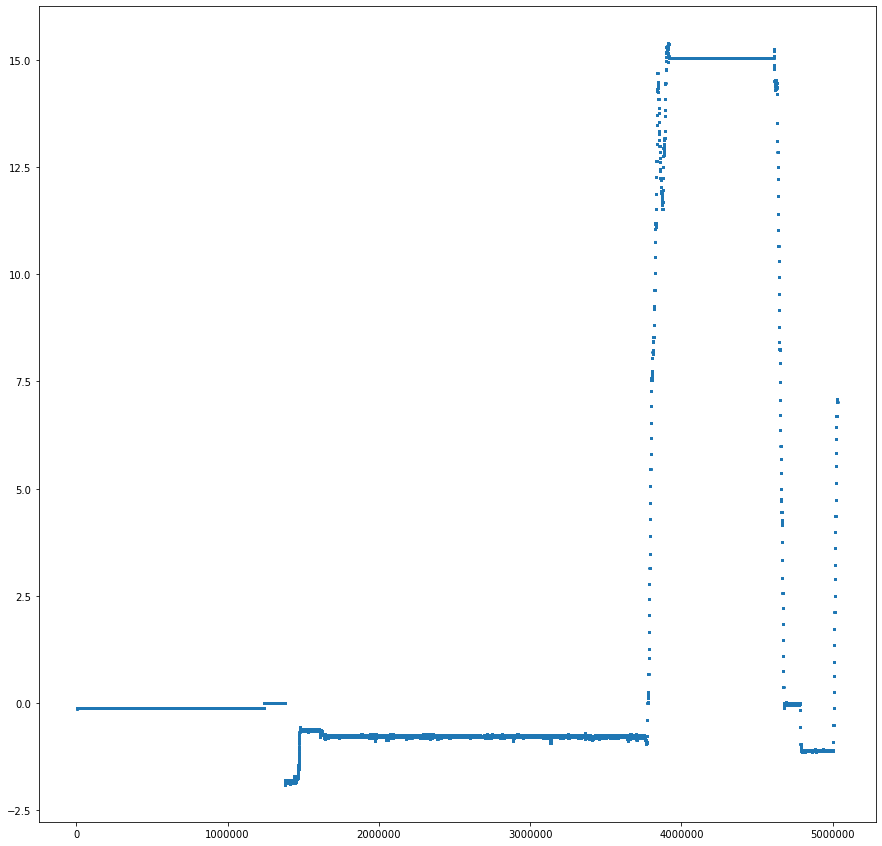

In [49]:
# pix_lat =  [float(str(decimal)[:-7])+float(str(decimal)[-7:])/10000000 for decimal in list(rov_log_df['GLOBAL_POSITION_INT.lat'])]
# pix_lon =  [float(str(decimal)[:-7])-float(str(decimal)[-7:])/10000000 for decimal in list(rov_log_df['GLOBAL_POSITION_INT.lon'])]

# plt.figure(figsize=(15, 15))
# plt.scatter(pix_lon,pix_lat, s=4)
# f = 1.0/np.cos(56.4*np.pi/180)
# plt.gca().set_aspect(f)
# plt.ticklabel_format(useOffset=False)
# plt.gca().ticklabel_format(style='plain')


plt.figure(figsize=(15, 15))
plt.scatter(rov_log_df["GLOBAL_POSITION_INT.time_boot_ms"],rov_log_df['VFR_HUD.alt'], s=4)

plt.ticklabel_format(useOffset=False)
plt.gca().ticklabel_format(style='plain')
